<a href="https://colab.research.google.com/github/nameonwoo/math/blob/main/ch08_bi_classify_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8장 로지스텍 회귀 모델(이진 분류)

In [1]:
# 필요 라이브러리 선언
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# PDF 출력
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

<ipython-input-2-324a830845c1>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


### 시그모이드 함수의 그래프
그림 8-4

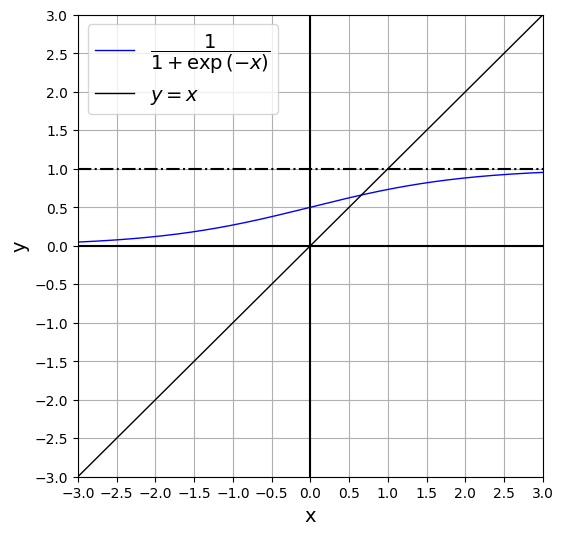

In [3]:
xx = np.linspace(-6, 6, 500)
yy = 1 / (np.exp(-xx) + 1)

plt.figure(figsize=(6,6))
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.xticks(np.linspace(-3,3,13))
plt.yticks(np.linspace(-3,3,13))
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.grid()
plt.plot(xx, yy, c='b', label=r'$\dfrac{1}{1+\exp{(-x)}}$', lw=1)
plt.plot(xx, xx, c='k', label=r'$y = x$', lw=1)
plt.plot([-3,3], [0,0], c='k')
plt.plot([0,0], [-3,3],c='k')
plt.plot([-3,3],[1,1],linestyle='-.',c='k')
plt.legend(fontsize=14)
plt.show()

### 데이터 준비

In [7]:
# 학습용 데이터 준비
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target
print('원본 데이터', x_org.shape, y_org.shape)

원본 데이터 (150, 4) (150,)


In [8]:
# 데이터 추출
#   클래스 0, 1만
#   항목 sepal_length과 sepal_width만
x_data, y_data = iris.data[:100,:2], iris.target[:100]
print('대상 데이터', x_data.shape, y_data.shape)

대상 데이터 (100, 2) (100,)


In [9]:
# 더미 변수를 추가
x_data = np.insert(x_data, 0, 1.0, axis=1)
print('더미 변수를 추가 한 후', x_data.shape)

더미 변수를 추가 한 후 (100, 3)


In [10]:
# 원본 데이터의 크기
print(x_data.shape, y_data.shape)
# 학습 데이터, 검증 데이터로 분할 (셔플도 함께 실시)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 3) (100,)
(70, 3) (30, 3) (70,) (30,)


### 학습 데이터의 산점도 표시

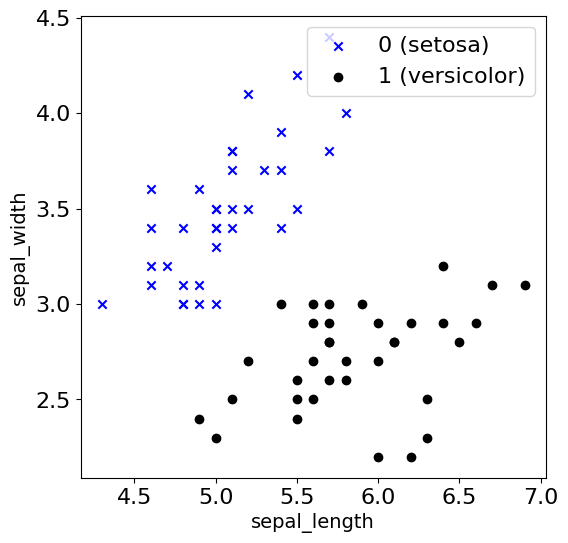

In [12]:
# 산점도 표시
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', c='k', label='1 (versicolor)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('sepal_width', fontsize=14)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

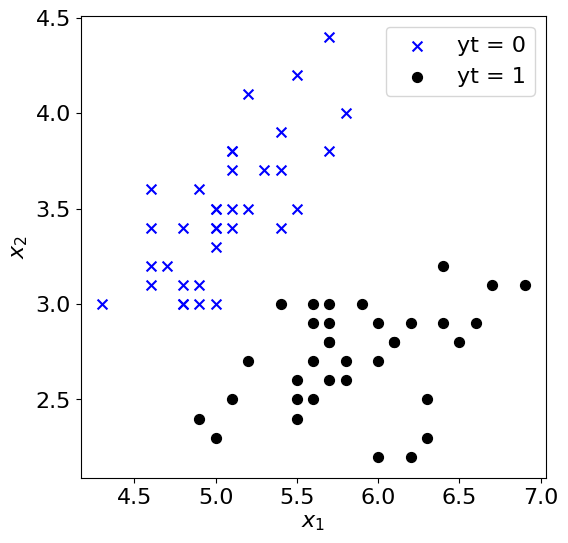

In [13]:
# 산점도 표시
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', s=50, c='b', label='yt = 0')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', s=50, c='k', label='yt = 1')
plt.xlabel(r'$x_1$', fontsize=16)
plt.ylabel(r'$x_2$', fontsize=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

### 학습용 변수 설정

In [14]:
# 학습용 변수 설정
x = x_train
yt = y_train

In [15]:
# 입력 데이터 x의 표시(더미 데이터를 포함)
print(x[:5])

[[1.  5.1 3.7]
 [1.  5.5 2.6]
 [1.  5.5 4.2]
 [1.  5.6 2.5]
 [1.  5.4 3. ]]


In [17]:
# 정답 데이터 y의 표시
print(yt[:5])

[0 1 0 1 1]


### 예측 함수

In [18]:
# 시그모이드 함수
def sigmoid(x):
    return 1/(1+ np.exp(-x))

In [19]:
# 예측값 계산
def pred(x, w):
    return sigmoid(x @ w)

### 평가

In [21]:
# 손실함수(교차 엔트로피 함수)
def cross_entropy(yt, yp):
    # 교차 엔트로피의 계산 (이 단계에서는 벡터)
    ce1 = -(yt * np.log(yp) + (1 - yt) * np.log(1 - yp))
    # 교차 엔트로피 벡터의 평균값을 계산
    return(np.mean(ce1))

In [22]:
# 예측 결과의 확률값에서 0이나 1을 판단하는 함수
def classify(y):
    return np.where(y < 0.5, 0, 1)

In [23]:
# 모델을 평가하는 함수
from sklearn.metrics import accuracy_score
def evaluate(xt, yt, w):

    # 예측값 계산
    yp = pred(xt, w)

    # 손실함수 값 계산
    loss = cross_entropy(yt, yp)

    # 예측값(확률값)을 0이나 1로 변환
    yp_b = classify(yp)

    # 정확도 산출
    score = accuracy_score(yt, yp_b)
    return loss, score

### 초기화 처리

In [24]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원수(더미 변수를 포함)
D = x.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 초깃값
w = np.ones(D)

# 평가 결과 기록(손실함수와 정확도)
history = np.zeros((0,3))

### 주요 처리

In [25]:
# 반복 루프

for k in range(iters):

    # 예측값 계산 (8.6.1), (8.6.2)
    yp = pred(x, w)

    # 오차 계산 (8.6.4)
    yd = yp - yt

    # 경사하강법 적용 (8.6.6)
    w = w - alpha * (x.T @ yd) / M

    # 평가 결과 기록
    if ( k % 10 == 0):
        loss, score = evaluate(x_test, y_test, w)
        history = np.vstack((history,
            np.array([k, loss, score])))
        print( "iter = %d loss = %f score = %f"
            % (k, loss, score))

iter = 0 loss = 4.493842 score = 0.500000
iter = 10 loss = 3.565375 score = 0.500000
iter = 20 loss = 2.643280 score = 0.500000
iter = 30 loss = 1.762444 score = 0.500000
iter = 40 loss = 1.085375 score = 0.500000
iter = 50 loss = 0.818721 score = 0.500000
iter = 60 loss = 0.770934 score = 0.500000
iter = 70 loss = 0.761053 score = 0.333333
iter = 80 loss = 0.754468 score = 0.200000
iter = 90 loss = 0.747781 score = 0.166667
iter = 100 loss = 0.740979 score = 0.133333
iter = 110 loss = 0.734193 score = 0.166667
iter = 120 loss = 0.727485 score = 0.200000
iter = 130 loss = 0.720875 score = 0.200000
iter = 140 loss = 0.714368 score = 0.266667
iter = 150 loss = 0.707967 score = 0.300000
iter = 160 loss = 0.701670 score = 0.366667
iter = 170 loss = 0.695476 score = 0.433333
iter = 180 loss = 0.689383 score = 0.500000
iter = 190 loss = 0.683389 score = 0.566667
iter = 200 loss = 0.677493 score = 0.700000
iter = 210 loss = 0.671693 score = 0.700000
iter = 220 loss = 0.665988 score = 0.733333

### 결과 확인

In [26]:
# 손실함수의 값과 정확도 점검
print('[초기 상태] 손실함수: %f, 정확도: %f'
      % (history[0,1], history[0,2]))
print('[최종 상태] 손실함수: %f, 정확도: %f'
      % (history[-1,1], history[-1,2]))

[초기 상태] 손실함수: 4.493842, 정확도: 0.500000
[최종 상태] 손실함수: 0.153947, 정확도: 0.966667


In [28]:
# 검증 데이터를 산점도용으로 준비
x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

# 결정경계를 그리기 위해 x1의 값에서 x2의 값을 계산
def b(x, w):
    return(-(w[0] + w[1] * x)/ w[2])
# 산점도 x1의 최솟값과 최댓값
xl = np.asarray([x[:,1].min(), x[:,1].max()])
yl = b(xl, w)

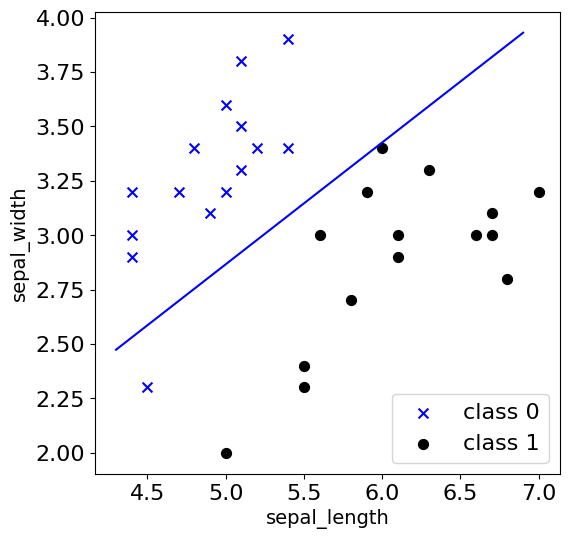

In [29]:
plt.figure(figsize=(6,6))
# 산점도 표시
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x',
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o',
        c='k', s=50, label='class 1')
# 산점도에 결정경계 직선을 추가
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('sepal_width', fontsize=14)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

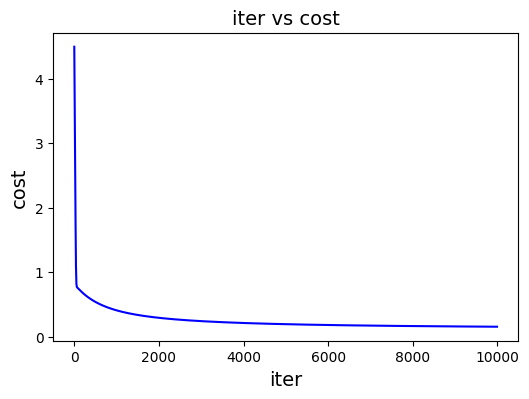

In [30]:
# 학습 곡선 표시 (손실 함수)
plt.figure(figsize=(6,4))
plt.plot(history[:,0], history[:,1], 'b')
plt.xlabel('iter', fontsize=14)
plt.ylabel('cost', fontsize=14)
plt.title('iter vs cost', fontsize=14)
plt.show()

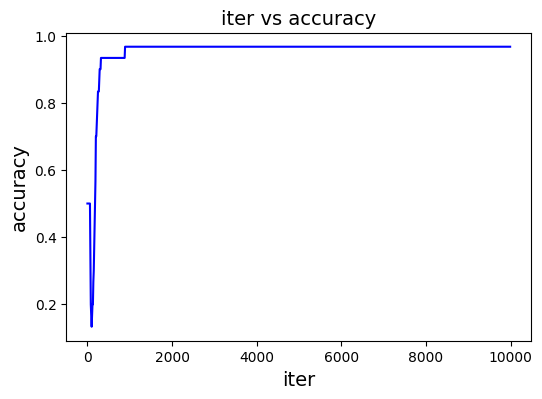

In [31]:
# 학습 곡선 표시 (정확도)
plt.figure(figsize=(6,4))
plt.plot(history[:,0], history[:,2], 'b')
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

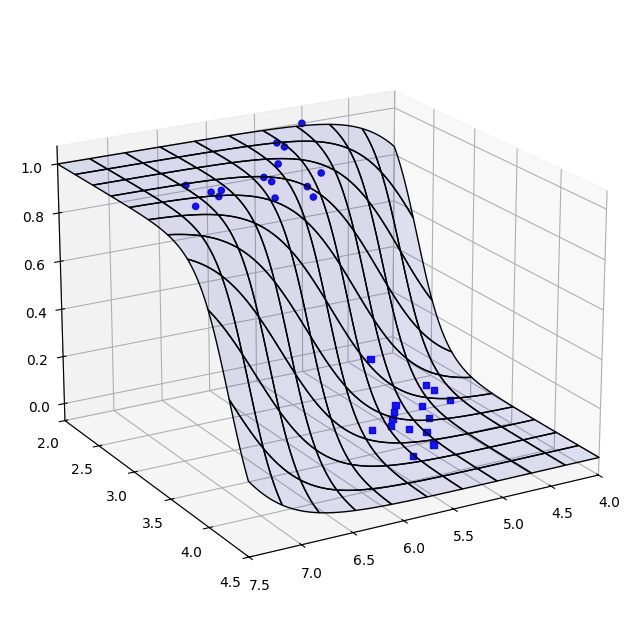

In [32]:
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 7.5, 100)
x2 = np.linspace(2, 4.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.asarray([np.ones(xx1.ravel().shape),
    xx1.ravel(), xx2.ravel()]).T
c = pred(xxx, w).reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c, color='blue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.1)
ax.scatter(x_t1[:,1], x_t1[:,2], 1, s=20, alpha=0.9, marker='o', c='b')
ax.scatter(x_t0[:,1], x_t0[:,2], 0, s=20, alpha=0.9, marker='s', c='b')
ax.set_xlim(4,7.5)
ax.set_ylim(2,4.5)
ax.view_init(elev=20, azim=60)

## scikit-learn 라이브러리 사용

In [33]:
# 필요한 라이브러리를 로드
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# 모델 생성
model_lr = LogisticRegression(solver='liblinear')
model_svm = svm.SVC(kernel='linear')

# 기계 학습 실시
model_lr.fit(x, yt)
model_svm.fit(x, yt)

SVC(kernel='linear')

In [34]:
# 선형 회귀
# 절편의 값
lr_w0 = model_lr.intercept_[0]
# x1(sepal_length)의 계수
lr_w1 = model_lr.coef_[0,1]
# x2(sepal_width)의 계수
lr_w2 = model_lr.coef_[0,2]

# SVM
# 절편의 값
svm_w0 = model_svm.intercept_[0]
# x1(sepal_length)의 계수
svm_w1 = model_svm.coef_[0,1]
# x2(sepal_width)의 계수
svm_w2 = model_svm.coef_[0,2]

In [35]:
# 한계 직선 그리기용 x1의 값에서 x2의 값을 계산
def rl(x):
    wk = lr_w0 + lr_w1 * x
    wk2 = -wk / lr_w2
    return(wk2)

In [36]:
# 한계 직선 그리기용 x1의 값에서 x2의 값을 계산
def svm(x):
    wk = svm_w0 + svm_w1 * x
    wk2 = -wk / svm_w2
    return(wk2)

In [37]:
y_rl = rl(xl)
y_svm = svm(xl)
# 결과 확인
print(xl, yl, y_rl, y_svm)

[4.3 6.9] [2.47353128 3.93052473] [2.50344682 4.05984593] [2.17911792 4.42574136]


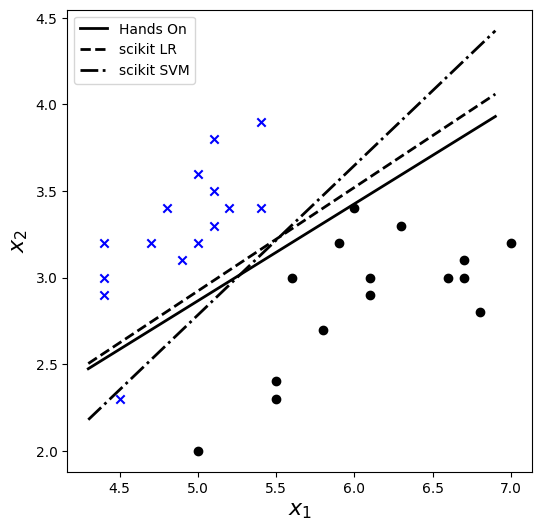

In [38]:
# 산점도에 한계 직선 추가
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
# 산점도의 표시
plt.scatter(x_t0[:,1], x_t0[:,2], marker='x', c='b')
plt.scatter(x_t1[:,1], x_t1[:,2], marker='o', c='k')
# 한계 직선의 표시
ax.plot(xl, yl, linewidth=2, c='k', label='Hands On')
# lr model
ax.plot(xl, y_rl, linewidth=2, c='k', linestyle="--", label='scikit LR')
# svm
ax.plot(xl, y_svm, linewidth=2, c='k', linestyle="-.", label='scikit SVM')

ax.legend()
ax.set_xlabel('$x_1$', fontsize=16)
ax.set_ylabel('$x_2$', fontsize=16)
plt.show()